In [1]:
# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Speaker Diarization in ASR pipeline:

ASR --> create VAD timestamps to obtain segments --> speaker diarization --> match the decoded words with speaker labels

In [2]:
import nemo.collections.asr as nemo_asr
import numpy as np
from IPython.display import Audio, display
import librosa
import os
import wget
import matplotlib.pyplot as plt

import nemo
import glob

import pprint
pp = pprint.PrettyPrinter(indent=4)

[NeMo W 2022-08-21 14:44:13 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


In [3]:
import shutil

# test with a very simple audio file

# path source
dir = os.path.dirname(os.getcwd())
AUDIO_FILENAME = os.path.join(dir, 'AudioProcessing/audios/3_speakers.wav')

# create destination folder
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'NeMo')
print(data_dir)
os.makedirs(data_dir, exist_ok=True)

shutil.copy(AUDIO_FILENAME, data_dir)

signal, sample_rate = librosa.load(AUDIO_FILENAME, sr=None)
display(Audio(signal, rate=sample_rate))

/home/kangying/Desktop/Code/AudioProcessing/NeMo


In [4]:
def display_waveform(signal,text='Audio',overlay_color=[]):
    fig,ax = plt.subplots(1,1)
    fig.set_figwidth(20)
    fig.set_figheight(2)
    plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c='k')
    if len(overlay_color):
        plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c=overlay_color)
    fig.suptitle(text, fontsize=16)
    plt.xlabel('time (secs)', fontsize=18)
    plt.ylabel('signal strength', fontsize=14);
    plt.axis([0,len(signal),-0.5,+0.5])
    time_axis,_ = plt.xticks();
    plt.xticks(time_axis[:-1],time_axis[:-1]/sample_rate);
    
COLORS="b g c m y".split()

def get_color(signal,speech_labels,sample_rate=16000):
    c=np.array(['k']*len(signal))
    for time_stamp in speech_labels:
        start,end,label=time_stamp.split()
        start,end = int(float(start)*16000),int(float(end)*16000),
        if label == "speech":
            code = 'red'
        else:
            code = COLORS[int(label.split('_')[-1])]
        c[start:end]=code
    
    return c 

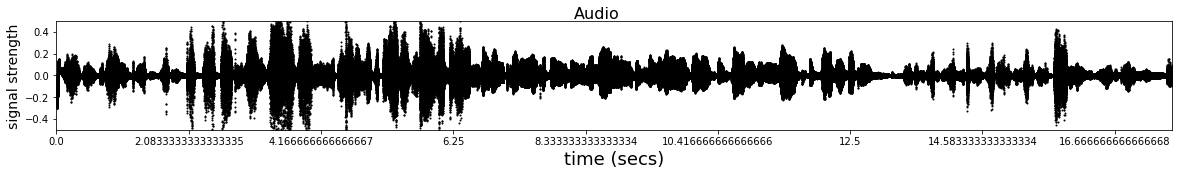

In [5]:
# display the waveform (time domain)
display_waveform(signal)

Parameter setting for ASR and diarization

In [6]:
from omegaconf import OmegaConf
import shutil

CONFIG_URL = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/offline_diarization_with_asr.yaml"
if not os.path.exists(os.path.join(data_dir,'offline_diarization_with_asr.yaml')):
    CONFIG = wget.download(CONFIG_URL, data_dir)
else:
    CONFIG = os.path.join(data_dir,'offline_diarization_with_asr.yaml')

cfg = OmegaConf.load(CONFIG)
# print(OmegaConf.to_yaml(cfg))

Create a manifest file where we specify the arguments expected by the Speaker Diatization script
1. manifest_filepath : Path to manifest file containing json lines of format: {"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath"="/path/to/uem/filepath"}
2. out_dir : directory where outputs and intermediate files are stored.
3. oracle_vad: If this is true then we extract speech activity labels from rttm files, if False then either
4. vad.model_path or external_manifestpath containing speech activity labels has to be passed.

In [7]:
# Create a manifest file for input with below format. 
# {"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-", 
# "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath"="/path/to/uem/filepath"}
import json
meta = {
    'audio_filepath': AUDIO_FILENAME, 
    'offset': 0, 
    'duration':None, 
    'label': 'infer', 
    'text': '-', 
    'num_speakers': 3, 
    'rttm_filepath': None, 
    'uem_filepath' : None
}
with open(os.path.join(data_dir,'input_manifest.json'),'w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

cfg.diarizer.manifest_filepath = os.path.join(data_dir,'input_manifest.json')
!cat {cfg.diarizer.manifest_filepath}

{"audio_filepath": "/home/kangying/Desktop/Code/AudioProcessing/audios/3_speakers.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 3, "rttm_filepath": null, "uem_filepath": null}


Now, we are able to set parameters required for diarization. We obtain voice activity labels from ASR, which is set through parameter 
cfg.diarizer.asr.parameters.asr_based_vad

In [17]:
pretraind_speaker_model = 'titanet_large'
cfg.diarizer.manifest_filepath = cfg.diarizer.manifest_filepath
cfg.diarizer.out_dir = data_dir     # directory to store intermidiate files and prediction outputs

cfg.diarizer.speaker_embeddings.model_path = pretraind_speaker_model
cfg.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
cfg.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
cfg.diarizer.clustering.parameters.oracle_num_speakers=True

# Using VAD generated from ASR timestamps
# cfg.diarizer.asr.model_path = 'stt_es_quartznet15x5'    # this model is fine-tuned from English to Spanish
cfg.diarizer.asr.model_path = 'QuartzNet15x5Base-En'
cfg.diarizer.oracle_vad = False # ----> Not using oracle VAD 
cfg.diarizer.asr.parameters.asr_based_vad = True
cfg.diarizer.asr.parameters.threshold=100 # ASR based VAD threshold: If 100, all silences under 1 sec are ignored.
cfg.diarizer.asr.parameters.decoder_delay_in_sec=0.2 # Decoder delay is compensated for 0.2 sec

Run ASR and get word stamps<br>
This is what we are gonna do before running speaker diarization. We will run ASR first and get the ASR output to generate decoded words and timestamps for those words.

In [18]:
from nemo.collections.asr.parts.utils.decoder_timestamps_utils import ASR_TIMESTAMPS

# create a decoder instance that returns an ASR model                                                                  
asr_ts_decoder = ASR_TIMESTAMPS(**cfg.diarizer)
asr_model = asr_ts_decoder.set_asr_model()

# run ASR
word_hyp, word_ts_hyp = asr_ts_decoder.run_ASR(asr_model)

print("Decoded word output dictionary: \n", word_hyp['3_speakers'])
print("Word-level timestamps dictionary: \n", word_ts_hyp['3_speakers'])


[NeMo I 2022-08-21 16:45:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-08-21 16:45:03 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-08-21 16:45:09 common:910] Instantiating model from pre-trained checkpoint
[NeMo I 2022-08-21 16:45:10 features:223] PADDING: 16
[NeMo I 2022-08-21 16:45:10 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


[NeMo W 2022-08-21 16:45:10 decoder_timestamps_utils:162] `ctc_decode` was set to True. Note that this is ignored.
[NeMo W 2022-08-21 16:45:10 nemo_logging:349] /home/kangying/anaconda3/envs/NeMo/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Decoded word output dictionary: 
 ['why', "it's", 'so', 'important', 'that', 'you', 'get', 'that', 'baby', 'right', 'away', 'right', 'soon', 'as', 'its', 'born', 'andyoi', 'the', 'sanction', 'and', 'pattern', 'recognition', 'are', 'a', 'very', 'interesting', 'area', 'that', 'has', 'been', 'studied', 'and', 'involved', 'for', 'several', 'decades', 'because', 'your', 'time', 'is', 'valuable', 'just', 'like', 'mine', 'so', 'when', 'i', 'find', 'one', 'th']
Word-level timestamps dictionary: 
 [[0.1, 0.6], [0.64, 0.82], [0.84, 0.92], [1.06, 1.5], [1.6, 1.7], [1.8, 2.0], [2.04, 2.16], [2.28, 2.5], [2.58, 2.92], [2.98, 3.18], [3.22, 3.72], [3.78, 3.92], [4.5, 4.68], [4.7, 4.84], [4.88, 5.06], [5.12, 5.4], [5.44, 6.14], [6.16, 6.26], [6.36, 6.84], [6.86, 6.94], [7.08, 7.42], [7.44, 8.14], [8.22, 8.3], [8.4, 8.44], [8.54, 8.82], [8.92, 9.42], [9.52, 9.8], [9.94, 10.04], [10.16, 10.24], [10.36, 10.52], [10.58, 10.9], [11.04, 11.12], [11.22, 11.62], [11.8, 11.88], [12.04, 12.34], [12.44, 13.8], [

Now we can create an instance <code>asr_diar_offline</code> that matches diarization results with ASR outputs.

In [19]:
from nemo.collections.asr.parts.utils.diarization_utils import ASR_DIAR_OFFLINE

# pass cfg.diarizer to set up the params for both ASR and diarization
asr_diar_offline = ASR_DIAR_OFFLINE(**cfg.diarizer)
# set word_ts_anchor_offset variable that determines the a  chor position of each word. Here we use the default value
asr_diar_offline.word_ts_anchor_offset = asr_ts_decoder.word_ts_anchor_offset

[NeMo I 2022-08-21 16:45:13 speaker_utils:82] Number of files to diarize: 1


Run Diarization with the extracted word timestamps<br>
All the components for diarization is ready.

In [20]:
# diar_hyp: diarization inderence result written in [start time][end time][speaker] format
# diar_score: contains None since we did not provide rttm_filepath in the input manifest file
diar_hyp, diar_score = asr_diar_offline.run_diarization(cfg, word_ts_hyp)
print("Diarization hypothesis output: \n", diar_hyp['3_speakers'])                                                                                

[NeMo I 2022-08-21 16:45:16 clustering_diarizer:154] Loading pretrained titanet_large model from NGC
[NeMo I 2022-08-21 16:45:16 cloud:56] Found existing object /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-08-21 16:45:16 cloud:62] Re-using file from: /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-08-21 16:45:16 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-08-21 16:45:17 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-08-21 16:45:17 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-08-21 16:45:17 features:223] PADDING: 16
[NeMo I 2022-08-21 16:45:17 label_models:98] loss is Angular Softmax


[NeMo W 2022-08-21 16:45:17 nemo_logging:349] /home/kangying/anaconda3/envs/NeMo/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_full_state_property`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-08-21 16:45:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-08-21 16:45:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-08-21 16:45:17 clustering_diarizer:279] Subsegmentation for embedding extraction: scale0, /home/kangying/Desktop/Code/AudioProcessing/NeMo/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-08-21 16:45:17 clustering_diarizer:334] Extracting embeddings for Diarization
[NeMo I 2022-08-21 16:45:17 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-08-21 16:45:17 collections:301] # 32 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]
[NeMo W 2022-08-21 16:45:18 speaker_utils:424] cuda=False, using CPU for Eigen decomposition. This might slow down the clustering process.
100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
[NeMo W 2022-08-21 16:45:19 speaker_utils:522] check if each ground truth RTTMs were present in provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2022-08-21 16:45:19 clustering_diarizer:453] Outputs are saved in /home/kangying/Desktop/Code/AudioProcessing/NeMo directory
Diarization hypothesis output: 
 ['0.1 0.9199999999999999 speaker_2', '1.06 1.5 speaker_2', '1.6 1.7000000000000002 speaker_1', '1.8 2.16 speaker_2', '2.28 2.5 speaker_2', '2.58 2.92 speaker_2', '2.98 3.7199999999999998 speaker_2', '3.78 3.92 speaker_1', '4.5 5.0600000000000005 speaker_2', '5.12 6.26 speaker_2', '6.36 6.94 speaker_1', '7.08 8.14 speaker_1', '8.22 8.3 speaker_0', '8.54 8.819999999999999 speaker_1', '8.92 9.42 speaker_1', '9.52 9.799999999999999 speaker_1', '9.94 10.04 speaker_1', '10.16 10.24 speaker_2', '10.36 10.52 speaker_1', '10.58 10.9 speaker_1', '11.04 11.12 speaker_1', '11.22 11.620000000000001 speaker_1', '11.8 11.88 speaker_1', '12.04 12.34 speaker_1', '12.44 14.66 speaker_0', '14.74 15.120000000000001 speaker_0', '15.18 15.42 speaker_0', '15.5 15.74 speaker_0', '15.86 16.48 speaker_0', '16.74 16.959999999999997 speaker_0', '17.0

<code>run_diarization()</code> function also creates <code>3_speakers.rttm</code> file. Let's check what's in it.

[   'SPEAKER 3_speakers 1   0.100   0.820 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   1.060   0.440 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   1.600   0.100 <NA> <NA> speaker_1 <NA> <NA>',
    'SPEAKER 3_speakers 1   1.800   0.360 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   2.280   0.220 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   2.580   0.340 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   2.980   0.740 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   3.780   0.140 <NA> <NA> speaker_1 <NA> <NA>',
    'SPEAKER 3_speakers 1   4.500   0.560 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   5.120   1.140 <NA> <NA> speaker_2 <NA> <NA>',
    'SPEAKER 3_speakers 1   6.360   0.580 <NA> <NA> speaker_1 <NA> <NA>',
    'SPEAKER 3_speakers 1   7.080   1.060 <NA> <NA> speaker_1 <NA> <NA>',
    'SPEAKER 3_speakers 1   8.220   0.080 <NA> <NA> speaker_0 <NA> <NA>',
    'SPEAKER 3_speakers 1   8.540   0.

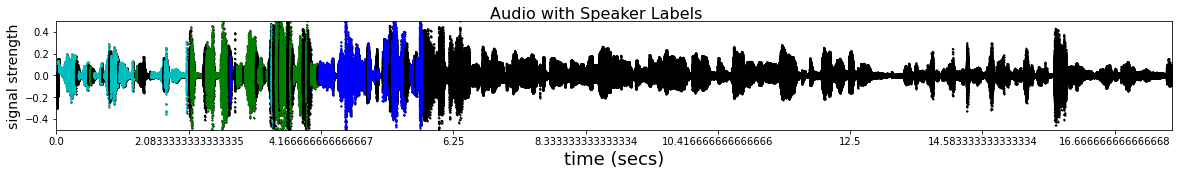

In [21]:
def read_file(path_to_file):
    with open(path_to_file) as f:
        contents = f.read().splitlines()
    return contents

predicted_speaker_label_rttm_path = f"{data_dir}/pred_rttms/3_speakers.rttm"
pred_rttm = read_file(predicted_speaker_label_rttm_path)

pp.pprint(pred_rttm)

from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels
pred_labels = rttm_to_labels(predicted_speaker_label_rttm_path)

color = get_color(signal, pred_labels)
display_waveform(signal,'Audio with Speaker Labels', color)
display(Audio(signal,rate=16000))
# Note that due to vscode jupyter extension bugs, the wav file is not playable here...

Check the speaker-labeled ASR transcription output<br>
Now we've done all the processes for running ASR and diarization, let's match the diarization result with the ASR result and get the final output.

In [22]:
# this function matches diarization output diar_hyp with word_hyp using the timestamp info from word_ts_hyp
asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)

[NeMo I 2022-08-21 16:45:42 diarization_utils:506] Creating results for Session: 3_speakers n_spk: 3 
[NeMo I 2022-08-21 16:45:42 diarization_utils:443] Diarization with ASR output files are saved in: /home/kangying/Desktop/Code/AudioProcessing/NeMo/pred_rttms


{'3_speakers': OrderedDict([('status', 'Success'),
              ('session_id', '3_speakers'),
              ('transcription',
               "why it's so important that you get that baby right away right soon as its born andyoi the sanction and pattern recognition are a very interesting area that has been studied and involved for several decades because your time is valuable just like mine so when i find one th"),
              ('speaker_count', 3),
              ('words',
               [{'word': 'why',
                 'start_time': 0.1,
                 'end_time': 0.6,
                 'speaker_label': 'speaker_2'},
                {'word': "it's",
                 'start_time': 0.64,
                 'end_time': 0.82,
                 'speaker_label': 'speaker_2'},
                {'word': 'so',
                 'start_time': 0.84,
                 'end_time': 0.92,
                 'speaker_label': 'speaker_2'},
                {'word': 'important',
                 'start_time'

After running get_transcript_with_speaker_labels() function, the transcription output will be located in **./pred_rttms** folder, which shows start time to end time of the utterance, speaker ID, and words spoken during the notified time.

In [24]:
transcription_path_to_file = f"{data_dir}/pred_rttms/3_speakers.txt"
transcript = read_file(transcription_path_to_file)
pp.pprint(transcript)

[   "[00:00.10 - 00:01.50] speaker_2: why it's so important",
    '[00:01.60 - 00:01.70] speaker_1: that',
    '[00:01.80 - 00:03.72] speaker_2: you get that baby right away',
    '[00:03.78 - 00:03.92] speaker_1: right',
    '[00:04.50 - 00:06.14] speaker_2: soon as its born andyoi',
    '[00:06.16 - 00:08.14] speaker_1: the sanction and pattern recognition',
    '[00:08.22 - 00:08.30] speaker_0: are',
    '[00:08.40 - 00:10.04] speaker_1: a very interesting area that',
    '[00:10.16 - 00:10.24] speaker_2: has',
    '[00:10.36 - 00:12.34] speaker_1: been studied and involved for several',
    '[00:12.44 - 00:17.38] speaker_0: decades because your time is valuable '
    'just like mine so when i find one th']


There is another output in JSON format saved in **./pred_rttms/an4_diarize_test.json**. <br>
In the JSON format output, we include information such as transcription, estimated number of speakers (variable named speaker_count), start and end time of each word and most importantly, speaker label for each word.

In [26]:
transcription_path_to_file = f"{data_dir}/pred_rttms/3_speakers.json"
json_contents = read_file(transcription_path_to_file)
pp.pprint(json_contents)

[   '{',
    '    "status": "Success",',
    '    "session_id": "3_speakers",',
    '    "transcription": "why it\'s so important that you get that baby right '
    'away right soon as its born andyoi the sanction and pattern recognition '
    'are a very interesting area that has been studied and involved for '
    'several decades because your time is valuable just like mine so when i '
    'find one th",',
    '    "speaker_count": 3,',
    '    "words": [',
    '        {',
    '            "word": "why",',
    '            "start_time": 0.1,',
    '            "end_time": 0.6,',
    '            "speaker_label": "speaker_2"',
    '        },',
    '        {',
    '            "word": "it\'s",',
    '            "start_time": 0.64,',
    '            "end_time": 0.82,',
    '            "speaker_label": "speaker_2"',
    '        },',
    '        {',
    '            "word": "so",',
    '            "start_time": 0.84,',
    '            "end_time": 0.92,',
    '            "spea